# <center> <b> <font color='blue'> BITCOIN PREDICTION </center> </b> </font>

## Table of Contents

1. [Problem Statement](#1)
2. [Setup](#2)
3. [Helper Functions](#3)
4. [Data Loading and pre-processing](#4)
5. [Models](#5)
6. [Comparing results](#6)
7. [Hyperparameter Tuning](#7)
8. [References](#References)

<a name="1"></a>
## <font color='#1a5276'> <b> 1. Problem Statement </font> </b>

We're going to be building a series of models in an attempt to predict the price of Bitcoin. 

<a name="2"></a>
## <font color='#1a5276'> <b> 2. Setup </font> </b>

In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os

<a name="3"></a>
## <font color='#1a5276'> <b> 3. Helper Functions </font> </b>

In [2]:
def plot_dataframe(dataframe, title, ylabel, figsize=(8, 5)):
    dataframe.plot(figsize=figsize)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    
    
def plot_train_vs_test(X_train, y_train, X_test, y_test, title, ylabel, xlabel, figsize=(8,5)):
    """
    X_train: np_array
    y_train: np_array
    ....
    """
    plt.figure(figsize=figsize)
    plt.scatter(X_train, y_train, s=5, label="Train data")
    plt.scatter(X_test, y_test, s=5, label="Test data")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(fontsize=12)
    plt.show()
    
    
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ---------
    timesteps : array of timesteps
    values : array of values across time
    format : style of plot, default "."
    start : where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (setting a value will index from end of timesteps & values)
    label : label to show on plot of values
    """
    # Plot the series
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)
    
    
    """
    Usage
        plt.figure(figsize=(10, 7))
        plot_time_series(timesteps=X_train, values=y_train, label="Train data")
        plot_time_series(timesteps=X_test, values=y_test, label="Test data")
    """


<a name="4"></a>
## <font color='#1a5276'> <b> 4. Loading data, visualization</font> </b>

### Get data

We're going to get the prices of Bitcoin from 01 October 2013 to 18 May 2021.

In [3]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

In [4]:
!ls

'10_time_series_forecasting_in_tensorflow (1).ipynb'
'Bitcoin Prediction.ipynb'
 BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


### Importing time series data with pandas


Because our data is in **CSV (comma separated values)** format, we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name of our date column ("Date").

In [5]:
# Parse dates and set date column to index
df = pd.read_csv("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


We can see that there are no missing values.

Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

In [7]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

This is something you'll run into with time series data problems. Often, the number of samples isn't as large as other kinds of data.

For example, collecting one sample at different time frames results in:

| 1 sample per timeframe | Number of samples per year |
| ----- | ----- |
| Second | 31,536,000 |
| Hour | 8,760 |
| Day | 365 |
| Week | 52 |
| Month | 12 |

To simplify, let's remove some of the columns from our data so we're only left with a date index and the closing price.

In [8]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


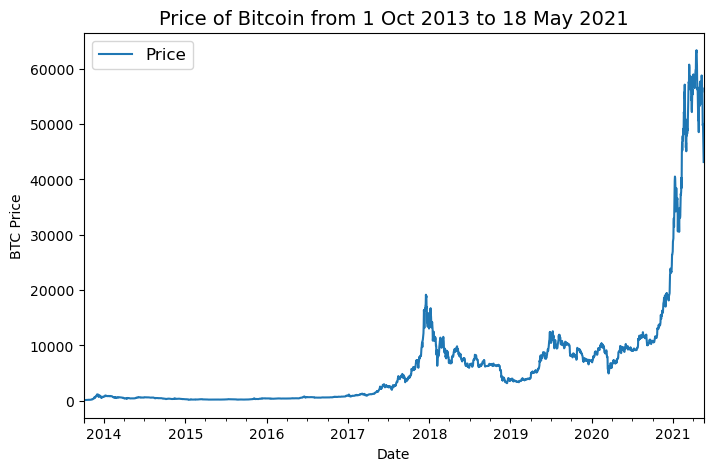

In [9]:
plot_dataframe(bitcoin_prices, "Price of Bitcoin from 1 Oct 2013 to 18 May 2021", "BTC Price")

Woah, looks like it would've been a good idea to buy Bitcoin back in 2014.

### Plot Train/Test Split

Let's turn our DataFrame index and column into NumPy arrays.

In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:5], prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [11]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

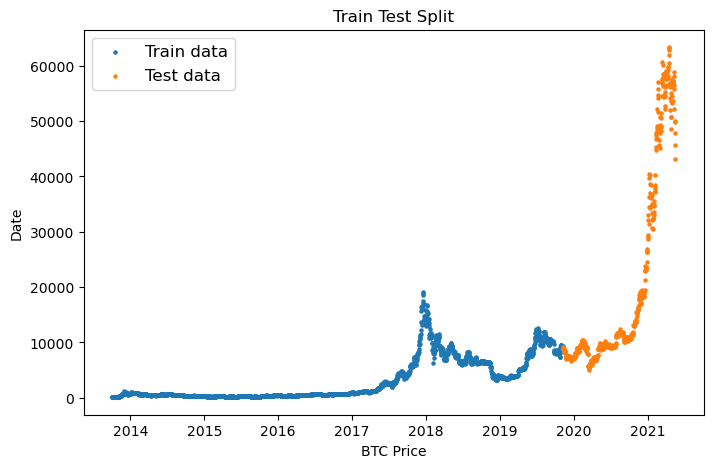

In [12]:
plot_train_vs_test(X_train, y_train, X_test, y_test, 'Train Test Split', 'Date', 'BTC Price')

We're going to be using the training set (past) to train a model to try and predict values on the test set (future).

Because the test set is an *artificial* future, we can guage how our model might perform on *actual* future data.

Is important to remember the test set is a pseudofuture and not the actual future, it is only meant to give you an indication of how the models you're building are performing. 

> 📖 **Resource:** Working with time series data can be tricky compared to other kinds of data. And there are a few pitfalls to watch out for, such as how much data to use for a test set. The article [*3 facts about time series forecasting that surprise experienced machine learning practitioners*](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387) talks about different things to watch out for when working with time series data.



<a name="5"></a>
## <font color='#1a5276'> <b> 5. Pre-processing </font> </b>

### Windowing dataset


We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**. 

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.


Now we'll write a function to take in an array and turn it into a window and horizon.

In [22]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [23]:
# Test out the window labelling function with window_size=7 and horizon=1
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=1)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we need a way to make windows for an entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage [NumPy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Let's write a function which:
1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses NumPy indexing to create a 2D of multiple window steps, for example: 
```
[[0, 1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7, 8],
 [2, 3, 4, 5, 6, 7, 8, 9]]
```
3. Uses the 2D array of multuple window steps to index on a target series
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

> 📖 **Resource:** The function created below has been adapted from Syafiq Kamarul Azman's article [*Fast and Robust Sliding Window Vectorization with NumPy*](https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5).

In [24]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    # print(f"Window step:\n {window_step}")

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

    # 3. Index on the target array (time series) with 2D array of multiple window steps
    windowed_array = x[window_indexes]

    # 4. Get the labelled windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels

In [25]:
full_windows, full_labels = make_windows(prices, window_size=7, horizon=1)
len(full_windows), len(full_labels)

(2780, 2780)

In [26]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [27]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> 🔑 **Note:** You can find a function which achieves similar results to the ones we implemented above at [`tf.keras.preprocessing.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

### Train/Test Split

In [28]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [29]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [31]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116]]))

In [33]:
# Check to see if same (accounting for horizon and window size)
HORIZON=1
WINDOW_SIZE=7

np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

<a name="6"></a>
## <font color='#1a5276'> <b> 6. Modeling Experiments </font> </b>

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**. 
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size |
| ----- | ----- | ----- | ----- | 
| 0 | Naïve model (baseline) | NA | NA |
| 1 | Dense model | 1 | 7 | 
| 2 | Same as 1 | 1 | 30 | 
| 3 | Same as 1 | 7 | 30 | 
| 4 | Conv1D | 1 | 7 | 
| 5 | LSTM | 1 | 7 | 
| 6 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | 
| 7 | Future prediction model (model to predict future values) | 1 | 7 | 


In [35]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

<a name="6.1"></a>
### <font color='#1f618d'> <b> 6.1. Model 0 (Baseline): Naive Forecast </font> </b>

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$ 

In English: 
> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).


In an open system (like a stock market or crypto market), you'll often find beating the naïve forecast with *any* kind of model is quite hard.

> 🔑 **Note:** For the sake of this notebook, an **open system** is a system where inputs and outputs can freely flow, such as a market (stock or crypto). Where as, a **closed system** the inputs and outputs are contained within the system (like a poker game with your buddies, you know the buy in and you know how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [13]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:3], naive_forecast[-3:] # View first 3 and last 3 

(array([9226.48582088, 8794.35864452, 8798.04205463]),
 array([50032.69313676, 47885.62525472, 45604.61575361]))

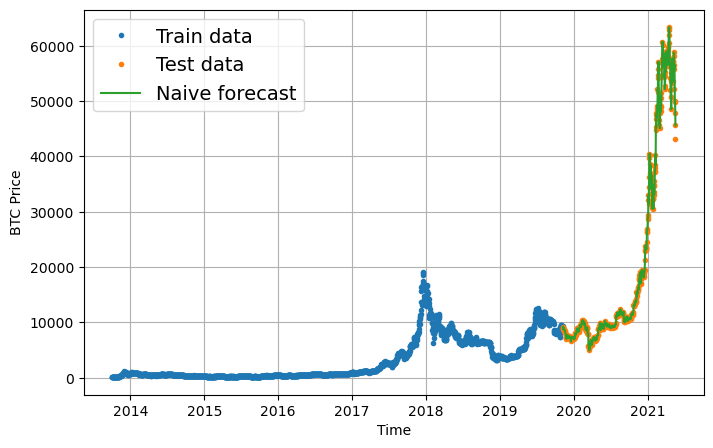

In [15]:
# Plot naive forecast
plt.figure(figsize=(8, 5))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well. 

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

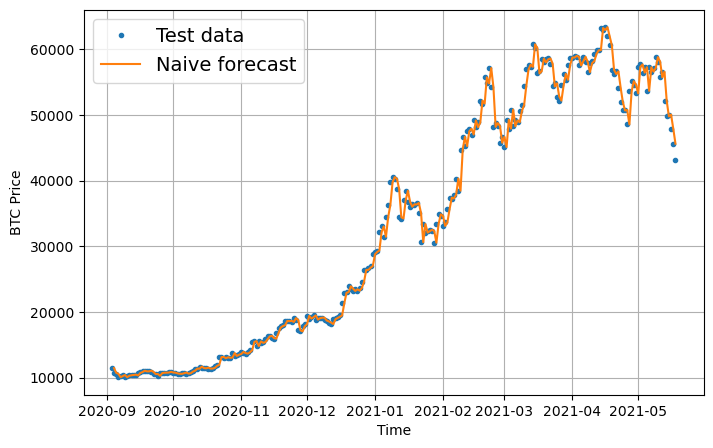

In [16]:
plt.figure(figsize=(8, 5))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

In [20]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [21]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737226

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?


### Make a modelling checkpoint


Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

> 🔑 **Note:** Because of the size of the dataset (smaller than usual), you'll notice our modelling experiment results fluctuate quite a bit during training (hence the implementation of the `ModelCheckpoint` callback to save the best model).

Because we're going to be running multiple experiments, it makes sense to keep track of them by saving models to file under different names.

To do this, we'll write a small function to create a `ModelCheckpoint` callback which saves a model to specified filename.


In [34]:
# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

<a name="6.2"></a>
### <font color='#1f618d'> <b> 6.2. Dense Model (window = 7, horizon = 1) </font> </b>

In [40]:
def build_compile_model_one(name):
    
    model = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
        ], name=name)
    
    model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
    
    return model

model_1 = build_compile_model_one("model_1_dense")    


In [44]:
# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback 
                                                                          # to save best model

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets


In [45]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 643.9089 - mae: 643.9089


[643.9088745117188, 643.9088745117188]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [46]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 1ms/step - loss: 563.7049 - mae: 563.7049


[563.7048950195312, 563.7048950195312]

Much better! Due to the fluctuating performance of the model during training, loading back in the best performing model see's a sizeable improvement in MAE.

### Making perdictions

In [48]:
# wrong way!!!
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [49]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:2]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([8854.837, 8807.255], dtype=float32)>)

> 🔑 **Note:** With these outputs, our model isn't *forecasting* yet. It's only making predictions on the test dataset. Forecasting would involve a model making predictions into the future, however, the test dataset is only a pseudofuture.

Excellent! Now we've got some prediction values, let's use the `evaluate_preds()` we created before to compare them to the ground truth.

In [50]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 563.70496,
 'mse': 1152782.8,
 'rmse': 1073.6772,
 'mape': 2.5098789,
 'mase': 0.9902735}

In [51]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [82]:
# RIGHT WAY
future_forecast = make_future_forecast(model=model_1,
                                       initial_window=y_train[-WINDOW_SIZE:],
                                       into_future=len(test_labels),
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 20ms/step
Predicting on: 
 [9131.41063031 9197.63234462 9290.89660239 9202.41545055 9369.62808116
 9326.59962378 9335.75240233] -> Prediction: 9357.505859375

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [9197.63234462 9290.89660239 9202.41545055 9369.62808116 9326.59962378
 9335.75240233 9357.50585938] -> Prediction: 9376.2607421875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [9290.89660239 9202.41545055 9369.62808116 9326.59962378 9335.75240233
 9357.50585938 9376.26074219] -> Prediction: 9396.1767578125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [9202.41545055 9369.62808116 9326.59962378 9335.75240233 9357.50585938
 9376.26074219 9396.17675781] -> Prediction: 9417.9189453125

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [9369.62808116 9326.59962378 9335.75240233 9357.50585938 9376.26074219
 9396.17675781 9417.91894531] -> Prediction: 9436.203

1/1 [==============================] - 0s 18ms/step
Predicting on: 
 [10051.21777344 10072.38378906 10093.59375    10114.84960938
 10136.1484375  10157.49316406 10178.88085938] -> Prediction: 10200.3115234375

1/1 [==============================] - 0s 14ms/step
Predicting on: 
 [10072.38378906 10093.59375    10114.84960938 10136.1484375
 10157.49316406 10178.88085938 10200.31152344] -> Prediction: 10221.7880859375

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [10093.59375    10114.84960938 10136.1484375  10157.49316406
 10178.88085938 10200.31152344 10221.78808594] -> Prediction: 10243.310546875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [10114.84960938 10136.1484375  10157.49316406 10178.88085938
 10200.31152344 10221.78808594 10243.31054688] -> Prediction: 10264.8779296875

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [10136.1484375  10157.49316406 10178.88085938 10200.31152344
 10221.78808594 10243.31054688 1

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [10910.16601562 10933.11914062 10956.11914062 10979.16796875
 11002.26367188 11025.40722656 11048.59863281] -> Prediction: 11071.841796875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [10933.11914062 10956.11914062 10979.16796875 11002.26367188
 11025.40722656 11048.59863281 11071.84179688] -> Prediction: 11095.1298828125

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [10956.11914062 10979.16796875 11002.26367188 11025.40722656
 11048.59863281 11071.84179688 11095.12988281] -> Prediction: 11118.4658203125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [10979.16796875 11002.26367188 11025.40722656 11048.59863281
 11071.84179688 11095.12988281 11118.46582031] -> Prediction: 11141.8525390625

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [11002.26367188 11025.40722656 11048.59863281 11071.84179688
 11095.12988281 11118.46582031 

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [11866.49609375 11891.4375     11916.42871094 11941.47265625
 11966.56933594 11991.71875    12016.91992188] -> Prediction: 12042.1728515625

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [11891.4375     11916.42871094 11941.47265625 11966.56933594
 11991.71875    12016.91992188 12042.17285156] -> Prediction: 12067.4794921875

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [11916.42871094 11941.47265625 11966.56933594 11991.71875
 12016.91992188 12042.17285156 12067.47949219] -> Prediction: 12092.8388671875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [11941.47265625 11966.56933594 11991.71875    12016.91992188
 12042.17285156 12067.47949219 12092.83886719] -> Prediction: 12118.2529296875

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [11966.56933594 11991.71875    12016.91992188 12042.17285156
 12067.47949219 12092.83886719 12

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [12878.62402344 12905.66699219 12932.76953125 12959.9296875
 12987.14160156 13014.41308594 13041.74316406] -> Prediction: 13069.1279296875

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [12905.66699219 12932.76953125 12959.9296875  12987.14160156
 13014.41308594 13041.74316406 13069.12792969] -> Prediction: 13096.5712890625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [12932.76953125 12959.9296875  12987.14160156 13014.41308594
 13041.74316406 13069.12792969 13096.57128906] -> Prediction: 13124.0693359375

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [12959.9296875  12987.14160156 13014.41308594 13041.74316406
 13069.12792969 13096.57128906 13124.06933594] -> Prediction: 13151.6279296875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [12987.14160156 13014.41308594 13041.74316406 13069.12792969
 13096.57128906 13124.06933594 

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [14005.48535156 14034.87304688 14064.32128906 14093.83203125
 14123.40234375 14153.03417969 14182.72851562] -> Prediction: 14212.484375

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [14034.87304688 14064.32128906 14093.83203125 14123.40234375
 14153.03417969 14182.72851562 14212.484375  ] -> Prediction: 14242.3056640625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [14064.32128906 14093.83203125 14123.40234375 14153.03417969
 14182.72851562 14212.484375   14242.30566406] -> Prediction: 14272.1845703125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [14093.83203125 14123.40234375 14153.03417969 14182.72851562
 14212.484375   14242.30566406 14272.18457031] -> Prediction: 14302.1318359375

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [14123.40234375 14153.03417969 14182.72851562 14212.484375
 14242.30566406 14272.18457031 14302

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [15198.07324219 15229.93945312 15261.87597656 15293.87695312
 15325.94433594 15358.07714844 15390.27832031] -> Prediction: 15422.5478515625

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [15229.93945312 15261.87597656 15293.87695312 15325.94433594
 15358.07714844 15390.27832031 15422.54785156] -> Prediction: 15454.884765625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [15261.87597656 15293.87695312 15325.94433594 15358.07714844
 15390.27832031 15422.54785156 15454.88476562] -> Prediction: 15487.28515625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [15293.87695312 15325.94433594 15358.07714844 15390.27832031
 15422.54785156 15454.88476562 15487.28515625] -> Prediction: 15519.7578125

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [15325.94433594 15358.07714844 15390.27832031 15422.54785156
 15454.88476562 15487.28515625 15519

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [16525.87109375 16560.5        16595.19921875 16629.97265625
 16664.8203125  16699.74023438 16734.73242188] -> Prediction: 16769.794921875

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [16560.5        16595.19921875 16629.97265625 16664.8203125
 16699.74023438 16734.73242188 16769.79492188] -> Prediction: 16804.931640625

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [16595.19921875 16629.97265625 16664.8203125  16699.74023438
 16734.73242188 16769.79492188 16804.93164062] -> Prediction: 16840.138671875

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [16629.97265625 16664.8203125  16699.74023438 16734.73242188
 16769.79492188 16804.93164062 16840.13867188] -> Prediction: 16875.423828125

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [16664.8203125  16699.74023438 16734.73242188 16769.79492188
 16804.93164062 16840.13867188 1687

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [17968.73632812 18006.36328125 18044.07226562 18081.86523438
 18119.72851562 18157.67382812 18195.69335938] -> Prediction: 18233.794921875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [18006.36328125 18044.07226562 18081.86523438 18119.72851562
 18157.67382812 18195.69335938 18233.79492188] -> Prediction: 18271.9765625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [18044.07226562 18081.86523438 18119.72851562 18157.67382812
 18195.69335938 18233.79492188 18271.9765625 ] -> Prediction: 18310.236328125

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [18081.86523438 18119.72851562 18157.67382812 18195.69335938
 18233.79492188 18271.9765625  18310.23632812] -> Prediction: 18348.576171875

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [18119.72851562 18157.67382812 18195.69335938 18233.79492188
 18271.9765625  18310.23632812 18348

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [19536.60351562 19577.4921875  19618.46484375 19659.52539062
 19700.67382812 19741.90429688 19783.21875   ] -> Prediction: 19824.623046875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [19577.4921875  19618.46484375 19659.52539062 19700.67382812
 19741.90429688 19783.21875    19824.62304688] -> Prediction: 19866.107421875

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [19618.46484375 19659.52539062 19700.67382812 19741.90429688
 19783.21875    19824.62304688 19866.10742188] -> Prediction: 19907.68359375

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [19659.52539062 19700.67382812 19741.90429688 19783.21875
 19824.62304688 19866.10742188 19907.68359375] -> Prediction: 19949.33984375

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [19700.67382812 19741.90429688 19783.21875    19824.62304688
 19866.10742188 19907.68359375 19949.33

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [21240.29882812 21284.734375   21329.25585938 21373.87109375
 21418.58203125 21463.38085938 21508.27929688] -> Prediction: 21553.267578125

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [21284.734375   21329.25585938 21373.87109375 21418.58203125
 21463.38085938 21508.27929688 21553.26757812] -> Prediction: 21598.3515625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [21329.25585938 21373.87109375 21418.58203125 21463.38085938
 21508.27929688 21553.26757812 21598.3515625 ] -> Prediction: 21643.529296875

1/1 [==============================] - 0s 21ms/step
Predicting on: 
 [21373.87109375 21418.58203125 21463.38085938 21508.27929688
 21553.26757812 21598.3515625  21643.52929688] -> Prediction: 21688.80078125

1/1 [==============================] - 0s 19ms/step
Predicting on: 
 [21418.58203125 21463.38085938 21508.27929688 21553.26757812
 21598.3515625  21643.52929688 21688.

1/1 [==============================] - 0s 14ms/step
Predicting on: 
 [23091.59179688 23139.86914062 23188.25390625 23236.73632812
 23285.3203125  23334.00585938 23382.78710938] -> Prediction: 23431.67578125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [23139.86914062 23188.25390625 23236.73632812 23285.3203125
 23334.00585938 23382.78710938 23431.67578125] -> Prediction: 23480.66796875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [23188.25390625 23236.73632812 23285.3203125  23334.00585938
 23382.78710938 23431.67578125 23480.66796875] -> Prediction: 23529.759765625

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [23236.73632812 23285.3203125  23334.00585938 23382.78710938
 23431.67578125 23480.66796875 23529.75976562] -> Prediction: 23578.951171875

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [23285.3203125  23334.00585938 23382.78710938 23431.67578125
 23480.66796875 23529.75976562 23578.

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [25103.24804688 25155.71289062 25208.28710938 25260.97460938
 25313.76953125 25366.671875   25419.67773438] -> Prediction: 25472.80078125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [25155.71289062 25208.28710938 25260.97460938 25313.76953125
 25366.671875   25419.67773438 25472.80078125] -> Prediction: 25526.03125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [25208.28710938 25260.97460938 25313.76953125 25366.671875
 25419.67773438 25472.80078125 25526.03125   ] -> Prediction: 25579.376953125

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [25260.97460938 25313.76953125 25366.671875   25419.67773438
 25472.80078125 25526.03125    25579.37695312] -> Prediction: 25632.830078125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [25313.76953125 25366.671875   25419.67773438 25472.80078125
 25526.03125    25579.37695312 25632.8300

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [27289.1953125  27346.19921875 27403.32617188 27460.5703125
 27517.93945312 27575.42382812 27633.02734375] -> Prediction: 27690.751953125

1/1 [==============================] - 0s 17ms/step
Predicting on: 
 [27346.19921875 27403.32617188 27460.5703125  27517.93945312
 27575.42382812 27633.02734375 27690.75195312] -> Prediction: 27748.595703125

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [27403.32617188 27460.5703125  27517.93945312 27575.42382812
 27633.02734375 27690.75195312 27748.59570312] -> Prediction: 27806.5625

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [27460.5703125  27517.93945312 27575.42382812 27633.02734375
 27690.75195312 27748.59570312 27806.5625    ] -> Prediction: 27864.64453125

1/1 [==============================] - 0s 16ms/step
Predicting on: 
 [27517.93945312 27575.42382812 27633.02734375 27690.75195312
 27748.59570312 27806.5625     27864.6445

In [83]:
model_1_preds.shape

TensorShape([556])

In [84]:
type(future_forecast)

list

In [85]:
tensor = tf.convert_to_tensor(future_forecast, dtype=tf.float32)

In [86]:
tensor.shape

TensorShape([556])

In [87]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=tensor)
model_1_results

{'mae': 9036.483,
 'mse': 163083780.0,
 'rmse': 12770.426,
 'mape': 46.96248,
 'mase': 15.8745985}

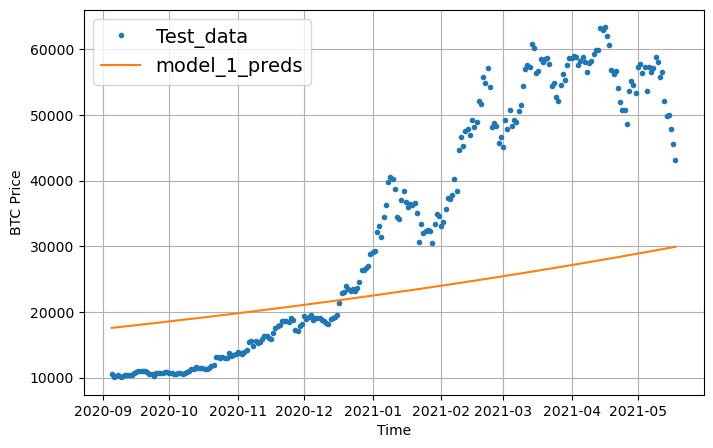

In [88]:
offset = 300
plt.figure(figsize=(8, 5))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tensor, start=offset, format="-", label="model_1_preds")

In [89]:
tensor

<tf.Tensor: shape=(556,), dtype=float32, numpy=
array([ 9357.506 ,  9376.261 ,  9396.177 ,  9417.919 ,  9436.203 ,
        9456.13  ,  9476.049 ,  9495.997 ,  9516.045 ,  9536.111 ,
        9556.178 ,  9576.32  ,  9596.497 ,  9616.718 ,  9636.982 ,
        9657.288 ,  9677.635 ,  9698.025 ,  9718.457 ,  9738.932 ,
        9759.447 ,  9780.006 ,  9800.609 ,  9821.257 ,  9841.944 ,
        9862.675 ,  9883.451 ,  9904.271 ,  9925.135 ,  9946.038 ,
        9966.985 ,  9987.977 , 10009.014 , 10030.094 , 10051.218 ,
       10072.384 , 10093.594 , 10114.85  , 10136.148 , 10157.493 ,
       10178.881 , 10200.312 , 10221.788 , 10243.311 , 10264.878 ,
       10286.489 , 10308.144 , 10329.845 , 10351.59  , 10373.38  ,
       10395.216 , 10417.098 , 10439.025 , 10460.998 , 10483.016 ,
       10505.081 , 10527.19  , 10549.347 , 10571.55  , 10593.8   ,
       10616.094 , 10638.432 , 10660.819 , 10683.253 , 10705.731 ,
       10728.258 , 10750.832 , 10773.452 , 10796.12  , 10818.833 ,
       10841.5

In [90]:
test_labels

array([[ 8798.04205463],
       [ 9081.18687849],
       [ 8711.53433917],
       [ 8760.89271814],
       [ 8749.52059102],
       [ 8656.97092235],
       [ 8500.64355816],
       [ 8469.2608989 ],
       [ 8537.33965197],
       [ 8205.80636599],
       [ 8118.4885358 ],
       [ 8074.84317361],
       [ 7612.7405735 ],
       [ 7262.11053495],
       [ 7303.40575852],
       [ 7041.73293642],
       [ 7211.86180875],
       [ 7141.06944869],
       [ 7523.4806726 ],
       [ 7390.20746923],
       [ 7729.26593894],
       [ 7542.23560864],
       [ 7381.96300782],
       [ 7333.43293049],
       [ 7315.36776456],
       [ 7213.73376172],
       [ 7398.78704961],
       [ 7511.88058312],
       [ 7532.12351309],
       [ 7550.23919987],
       [ 7333.09604316],
       [ 7239.76257544],
       [ 7198.06667705],
       [ 7190.27236926],
       [ 7238.87432299],
       [ 7087.02498535],
       [ 7112.73147612],
       [ 6883.49639377],
       [ 6584.02884335],
       [ 7424.01540023],


### Plot

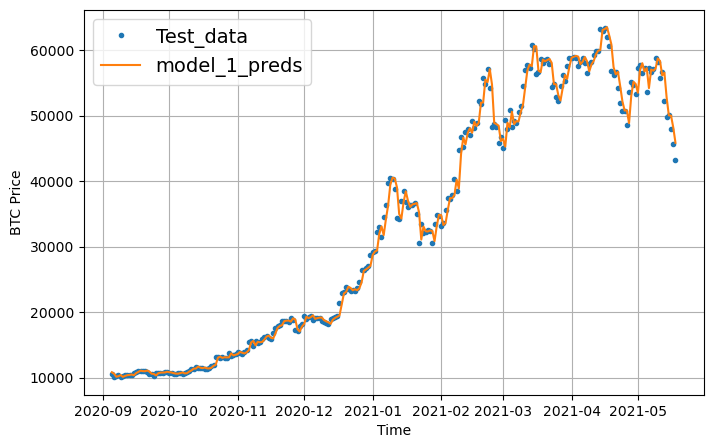

In [53]:
offset = 300
plt.figure(figsize=(8, 5))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

What's wrong with these predictions?

As mentioned before, they're on the test dataset. So they're not actual forecasts.

With our current model setup, how do you think we'd make forecasts for the future?

Have a think about it for now, we'll cover this later on.

<a name="5"></a>
## <font color='#1a5276'> <b> Evaluation </font> </b>

## Evaluating a time series model

Time series forecasting often involves predicting a number (in our case, the price of Bitcoin).

And what kind of problem is predicting a number?

Regression.

With this known, we can use regression evaluation metrics to evaluate our time series forecasts.

The main thing we will be evaluating is: **how do our model's predictions (`y_pred`) compare against the actual values (`y_true` or *ground truth values*)**? 

> 📖 **Resource:** We're going to be using several metrics to evaluate our different model's time series forecast accuracy. Many of them are sourced and explained mathematically and conceptually in [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html).

For all of the following metrics, **lower is better** (for example an MAE of 0 is better than an MAE 100).

### Scale-dependent errors

These are metrics which can be used to compare time series values and forecasts that are on the same scale.

For example, Bitcoin historical prices in USD versus Bitcoin forecast values in USD.

| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) | 
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

> 🤔 **Question:** There are so many metrics... which one should I pay most attention to? It's going to depend on your problem. However, since its ease of interpretation (you can explain it in a sentence to your grandma), MAE is often a very good place to start.

Since we're going to be evaluing a lot of models, let's write a function to help us calculate evaluation metrics on their forecasts.



In [17]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
# tf does not implement MASE
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [19]:
def evaluate_preds(y_true, y_pred):
    # Make sure float32 (for metric calculations)
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

![flowchart representation prediction loop to make forecasts and then append forecasts to data and make more forecasts continuously until forecast horizon is exhausted](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-prediction-loop-for-forecasts.png)
*Example flow chart representing the loop we're about to create for making forecasts. Not pictured: retraining a forecasting model every time a forecast is made & new data is acquired. For example, if you're predicting the price of Bitcoin daily, you'd want to retrain your model every day, since each day you're going to have a new data point to work with.*

Alright, let's create a function which returns `INTO_FUTURE` forecasted values using a trained model.

To do so, we'll build the following steps:
1. Function which takes as input: 
  * a list of values (the Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last `WINDOW_SIZE` values from the input values (predictions will start from the last `WINDOW_SIZE` values of the training data)
3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` datasets which update to remove the first the value and append the latest prediction 
  * Eventually future predictions will be made using the model's own previous predictions as input

In [ ]:
#def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:

# 1. Create function to make predictions into the future
def make_future_forecast(model, initial_window, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  
    
  #last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)
  last_window = initial_window



  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    #print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

Nice! Time to bring BitPredict 💰📈 to life and make future forecasts of the price of Bitcoin.

> 🛠 **Exercise:** In terms of a forecasting model, what might another approach to our `make_future_forecasts()` function? Recall, that for making forecasts, you need to retrain a model each time you want to generate a new prediction. 
>
> So perhaps you could try to: make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain a model... etc. 
>
> As it is, the `make_future_forecasts()` function skips the retraining of a model part.

In [60]:
y_train

array([ 123.65499   ,  125.455     ,  108.58483   , ..., 9369.62808116,
       9326.59962378, 9335.75240233])

In [59]:
y_train[-WINDOW_SIZE:]

array([9131.41063031, 9197.63234462, 9290.89660239, 9202.41545055,
       9369.62808116, 9326.59962378, 9335.75240233])

In [64]:
INTO_FUTURE = 3 # para entrenar será la longitud del val set
WINDOW_SIZE = 7

# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(model=model_1,
                                       initial_window=y_train[-WINDOW_SIZE:],
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [9131.41063031 9197.63234462 9290.89660239 9202.41545055 9369.62808116
 9326.59962378 9335.75240233] -> Prediction: 9357.505859375

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [9197.63234462 9290.89660239 9202.41545055 9369.62808116 9326.59962378
 9335.75240233 9357.50585938] -> Prediction: 9376.2607421875

1/1 [==============================] - 0s 15ms/step
Predicting on: 
 [9290.89660239 9202.41545055 9369.62808116 9326.59962378 9335.75240233
 9357.50585938 9376.26074219] -> Prediction: 9396.1767578125

